# Examples of configuring and running NSGA-II

This notebook includes two examples where NSGA-II is used to solve a continuous and a binary multi-objective problems.

In [31]:
using metajul
using Dates

## Configure the algorithm to solve a continuous problem (Kursawe)

### Indicate the problem to solve

In [32]:
problem = kursawe()

ContinuousProblem{Float64}(Bounds{Float64}[Bounds{Float64}(-5.0, 5.0), Bounds{Float64}(-5.0, 5.0), Bounds{Float64}(-5.0, 5.0)], Function[metajul.var"#147#149"{Int64}(3), metajul.var"#148#150"{Int64}(3)], Function[], "Kursawe")

### A solver contains the algorithm components and parameters

In [21]:
solver::NSGAII = NSGAII()
solver.problem = problem
solver.populationSize = 100

100

In [22]:
solver.termination = TerminationByEvaluations(25000)
solver.mutation = PolynomialMutation(1.0/numberOfVariables(problem),20.0, problem.bounds)
solver.crossover = SBXCrossover(1.0, 20.0, problem.bounds)

SBXCrossover(1.0, 20.0, Bounds{Float64}[Bounds{Float64}(-5.0, 5.0), Bounds{Float64}(-5.0, 5.0), Bounds{Float64}(-5.0, 5.0)])

### Run the algorithm

In [23]:
startingTime = Dates.now()
optimize(solver)
endTime = Dates.now()

println("Computing time: ", (endTime - startingTime))

Computing time: 848 milliseconds


### Print the results

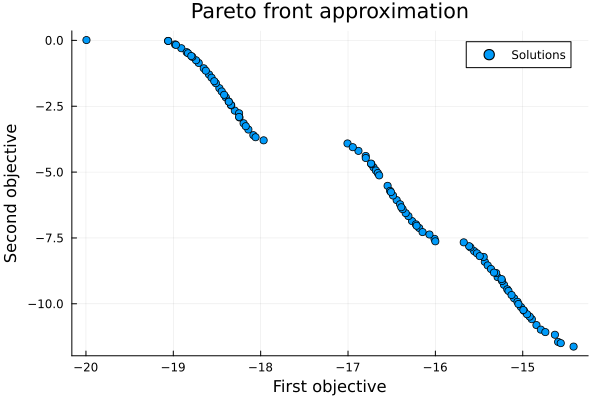

In [24]:
using Plots
 
#data to plot
x = [solution.objectives[1] for solution in solver.foundSolutions];
y = [solution.objectives[2] for solution in solver.foundSolutions];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")

## Configure the algorithm to solve a binary problem (OneZeroMax)

In [25]:
# The oneZeroMax function consists of miximizing the number of zeros and the number of ones in a binary string
problem = oneZeroMax(512)

BinaryProblem(512, Function[metajul.var"#179#182"(), metajul.var"#180#183"()], Function[], "OneZeroMax")

In [26]:
solver::NSGAII = NSGAII()
solver.problem = problem
solver.populationSize = 100

100

In [28]:
solver.termination = TerminationByEvaluations(25000)
solver.mutation = BitFlipMutation(1.0/numberOfVariables(problem))
solver.crossover = SinglePointCrossover(1.0)

SinglePointCrossover(1.0)

In [29]:
startingTime = Dates.now()
optimize(solver)
endTime = Dates.now()

println("Computing time: ", (endTime - startingTime))

Computing time: 2191 milliseconds


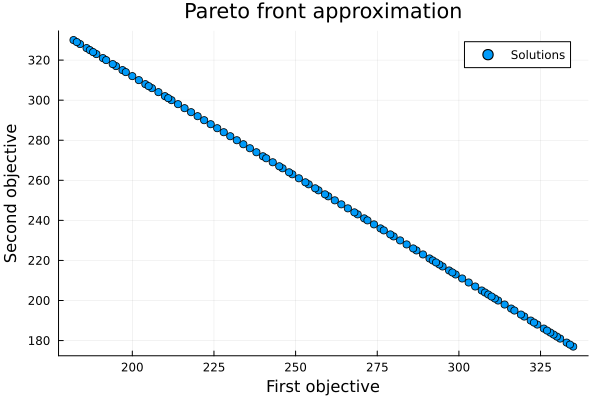

In [30]:
#data to plot
x = [solution.objectives[1] for solution in solver.foundSolutions];
y = [solution.objectives[2] for solution in solver.foundSolutions];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")